# Install Java, Spark, and Findspark
This installs Apache Spark 2.2.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

# 🎤 Common Voice Veri Seti - Apache Spark ile Preprocessing ve Eğitim

Bu notebook, Mozilla Common Voice veri setini indirip, Apache Spark ile preprocessing yaparak model eğitimi için hazırlar.

## İçindekiler:
1. Kütüphanelerin Kurulumu
2. Veri Setinin İndirilmesi
3. Spark Session Oluşturma
4. Veri Yükleme ve Keşif
5. Preprocessing Pipeline
6. Öznitelik Çıkarma (Feature Extraction)
7. Model Eğitimi
8. Değerlendirme

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3/"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('abc').master("local[*]").getOrCreate()
spark

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, udf, col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import FloatType
import pandas as pd
import time
import json
import os
import psutil
import gc
import urllib.request
from IPython.display import display, HTML

print(f"Pandas version: {pd.__version__}")

# Spark Oturumunu Başlatma
spark = SparkSession.builder.appName("HorovodMinimalExample").getOrCreate()
print(f"Spark Uygulama Adı: {spark.sparkContext.appName}")
print(f"TensorFlow Sürümü: {tf.__version__}")

Pandas version: 2.2.2
Spark Uygulama Adı: abc
TensorFlow Sürümü: 2.19.0


In [ ]:
# Benchmark sonuclarini saklayacagimiz sozluk
results = {
    'framework': 'pandas',
    'dataset': 'nyc_taxi_12_months',
    'operations': {}
}

def get_memory_mb():
    """Mevcut bellek kullanimini MB cinsinden dondur"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def benchmark(func, name):
    """Bir fonksiyonun calisma suresini ve bellek kullanimini olc"""
    gc.collect()
    mem_before = get_memory_mb()
    start = time.time()
    result = func()
    end = time.time()
    mem_after = get_memory_mb()

    duration = end - start
    mem_used = mem_after - mem_before

    results['operations'][name] = {
        'duration_sec': round(duration, 3),
        'memory_mb': round(mem_used, 2)
    }

    print(f"\n{'='*50}")
    print(f"Operation: {name}")
    print(f"Sure: {duration:.3f} saniye")
    print(f"Bellek: {mem_used:.2f} MB")
    print(f"{'='*50}")

    return result

In [ ]:
# =============================================================================
# 🎤 COMMON VOICE - SES SINIFLANDIRMA PROJESİ
# Yaş, Cinsiyet ve Aksan Tahmini
# =============================================================================
# Bu notebook: Kaggle → Spark → Polars → Ray Train
# =============================================================================

!pip install kaggle pyspark polars "ray[train]" librosa soundfile audioread tensorflow scikit-learn tqdm --quiet

print("✅ Tüm kütüphaneler kuruldu!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 36.3 MB/s eta 0:00:00
✅ Tüm kütüphaneler kuruldu!


In [ ]:
# Kütüphaneleri import et
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Spark kütüphaneleri
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, lit, udf, split, explode, lower, trim,
    regexp_replace, length, count, avg, max, min, sum,
    array, struct, concat, concat_ws
)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType,
    FloatType, ArrayType, DoubleType
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, VectorAssembler, StandardScaler,
    MinMaxScaler, PCA, OneHotEncoder
)
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier,
    GBTClassifier, MultilayerPerceptronClassifier
)
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Ses işleme
import librosa
import soundfile as sf

print("✅ Tüm kütüphaneler başarıyla yüklendi!")

✅ Tüm kütüphaneler başarıyla yüklendi!


In [ ]:
# # =============================================================================
# # KAGGLE API AYARLARI
# # =============================================================================
# # 1. kaggle.com → Account → Create New API Token
# # 2. kaggle.json dosyasını indirin
# # 3. Aşağıya yükleyin

# from google.colab import files

# print("📁 kaggle.json dosyanızı yükleyin:")
# uploaded = files.upload()

# # Kaggle klasörüne taşı
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# print("✅ Kaggle API yapılandırıldı!")


# =============================================================================
# KAGGLE API AYARLARI (Drive üzerinden)
# =============================================================================
import os

# Kaggle json dosyasının yolu
kaggle_json_path = "/content/drive/MyDrive/elif/kaggle.json"

# Kaggle klasörüne kopyala
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.system(f"cp {kaggle_json_path} ~/.kaggle/kaggle.json")
os.system("chmod 600 ~/.kaggle/kaggle.json")

print("✅ Kaggle API yapılandırıldı!")


✅ Kaggle API yapılandırıldı!


In [ ]:
# =============================================================================
# COMMON VOICE VERİ SETİNİ İNDİR
# =============================================================================

DATASET_NAME = "mozillaorg/common-voice"
DATA_DIR = "/content/common-voice"

print(f"📥 {DATASET_NAME} indiriliyor...")
print("⏳ Bu işlem birkaç dakika sürebilir...")

!kaggle datasets download -d {DATASET_NAME} -p {DATA_DIR} --unzip

print(f"\n✅ Veri indirildi: {DATA_DIR}")
!ls -la {DATA_DIR}

📥 mozillaorg/common-voice indiriliyor...
⏳ Bu işlem birkaç dakika sürebilir...
Dataset URL: https://www.kaggle.com/datasets/mozillaorg/common-voice
License(s): CC0-1.0
100% 12.0G/12.0G [00:26<00:00, 374MB/s]
100% 12.0G/12.0G [00:27<00:00, 478MB/s]

✅ Veri indirildi: /content/common-voice
total 35396
drwxr-xr-x 9 root root     4096 Dec 22 14:45 .
drwxr-xr-x 1 root root     4096 Dec 22 14:43 ..
drwxr-xr-x 3 root root     4096 Dec 22 14:43 cv-invalid
-rw-r--r-- 1 root root  2361277 Dec 22 14:43 cv-invalid.csv
drwxr-xr-x 3 root root     4096 Dec 22 14:43 cv-other-dev
-rw-r--r-- 1 root root   272718 Dec 22 14:43 cv-other-dev.csv
drwxr-xr-x 3 root root     4096 Dec 22 14:43 cv-other-test
-rw-r--r-- 1 root root   271587 Dec 22 14:43 cv-other-test.csv
drwxr-xr-x 3 root root     4096 Dec 22 14:43 cv-other-train
-rw-r--r-- 1 root root 13420832 Dec 22 14:43 cv-other-train.csv
drwxr-xr-x 3 root root     4096 Dec 22 14:44 cv-valid-dev
-rw-r--r-- 1 root root   388392 Dec 22 14:44 cv-valid-dev.csv
dr

In [ ]:
# =============================================================================
# VERİ YAPISINI KEŞFET VE YÜKLE (CSV)
# =============================================================================

import os
import pandas as pd

DATA_DIR = "/content/common-voice"

# CSV dosyalarını listele
csv_files = []
for file in os.listdir(DATA_DIR):
    if file.endswith('.csv'):
        csv_files.append(file)

print(f"📂 Bulunan CSV dosyaları:")
for f in csv_files:
    print(f"   - {f}")

# En büyük train dosyasını kullanalım (cv-valid-train.csv)
CSV_PATH = f"{DATA_DIR}/cv-valid-train.csv"

# Önce Pandas ile yapıyı inceleyelim
print(f"\n📊 {CSV_PATH} inceleniyor...")
df_sample = pd.read_csv(CSV_PATH, nrows=5)
print(f"\n📋 Sütunlar: {df_sample.columns.tolist()}")
print(f"\n📊 İlk 5 satır:")
print(df_sample)

📂 Bulunan CSV dosyaları:
   - cv-other-train.csv
   - cv-valid-train.csv
   - cv-invalid.csv
   - cv-other-dev.csv
   - cv-other-test.csv
   - cv-valid-test.csv
   - cv-valid-dev.csv

📊 /content/common-voice/cv-valid-train.csv inceleniyor...

📋 Sütunlar: ['filename', 'text', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration']

📊 İlk 5 satır:
                           filename  \
0  cv-valid-train/sample-000000.mp3   
1  cv-valid-train/sample-000001.mp3   
2  cv-valid-train/sample-000002.mp3   
3  cv-valid-train/sample-000003.mp3   
4  cv-valid-train/sample-000004.mp3   

                                                text  up_votes  down_votes  \
0  learn to recognize omens and follow them the o...         1           0   
1         everything in the universe evolved he said         1           0   
2  you came so that you could learn about your dr...         1           0   
3  so now i fear nothing because it was those ome...         1           0   
4  if you start yo

In [ ]:
 0   filename    5 non-null      object
 1   text        5 non-null      object
 2   up_votes    5 non-null      int64
 3   down_votes  5 non-null      int64
 4   age         0 non-null      float64
 5   gender      0 non-null      float64
 6   accent      0 non-null      float64
 7   duration

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    5 non-null      object 
 1   text        5 non-null      object 
 2   up_votes    5 non-null      int64  
 3   down_votes  5 non-null      int64  
 4   age         0 non-null      float64
 5   gender      0 non-null      float64
 6   accent      0 non-null      float64
 7   duration    0 non-null      float64
dtypes: float64(4), int64(2), object(2)
memory usage: 452.0+ bytes


In [ ]:
# =============================================================================
# SPARK SESSION OLUŞTURMA
# =============================================================================

def create_spark_session(app_name="CommonVoicePreprocessing", memory="4g"):
    """
    Spark session oluşturur

    Parameters:
    -----------
    app_name : str
        Uygulama adı
    memory : str
        Driver ve executor bellek miktarı

    Returns:
    --------
    SparkSession
    """
    spark = SparkSession.builder \
        .appName(app_name) \
        .config("spark.driver.memory", memory) \
        .config("spark.executor.memory", memory) \
        .config("spark.sql.shuffle.partitions", "8") \
        .config("spark.default.parallelism", "8") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .getOrCreate()

    # Log seviyesini ayarla
    spark.sparkContext.setLogLevel("WARN")

    return spark

# Spark session başlat
spark = create_spark_session()

print("✅ Spark Session oluşturuldu!")
print(f"📌 Spark Version: {spark.version}")
print(f"📌 App Name: {spark.sparkContext.appName}")
print(f"📌 Master: {spark.sparkContext.master}")

✅ Spark Session oluşturuldu!
📌 Spark Version: 3.4.4
📌 App Name: abc
📌 Master: local[*]


In [ ]:
# =============================================================================
# SES DOSYALARININ KONUMUNU BUL
# =============================================================================

# Klasör yapısını incele
print("📂 Klasör yapısı:")
for item in os.listdir(DATA_DIR):
    item_path = os.path.join(DATA_DIR, item)
    if os.path.isdir(item_path):
        sub_items = os.listdir(item_path)[:5]
        print(f"   📁 {item}/ → {sub_items}")

# cv-valid-train klasöründeki ses dosyaları
AUDIO_DIR = f"{DATA_DIR}/cv-valid-train"
if os.path.exists(AUDIO_DIR):
    audio_files = os.listdir(AUDIO_DIR)[:10]
    print(f"\n🎵 Ses dosyaları ({AUDIO_DIR}):")
    for f in audio_files:
        print(f"   - {f}")

📂 Klasör yapısı:
   📁 cv-other-train/ → ['cv-other-train']
   📁 cv-other-dev/ → ['cv-other-dev']
   📁 cv-valid-dev/ → ['cv-valid-dev']
   📁 cv-invalid/ → ['cv-invalid']
   📁 cv-other-test/ → ['cv-other-test']
   📁 cv-valid-test/ → ['cv-valid-test']
   📁 cv-valid-train/ → ['cv-valid-train']

🎵 Ses dosyaları (/content/common-voice/cv-valid-train):
   - cv-valid-train


In [ ]:
# =============================================================================
# VERİ YÜKLEME
# =============================================================================

# Common Voice veri seti genellikle TSV formatında metadata içerir
# Dosya yapısına göre yolu güncelleyin
import glob
def load_metadata(spark, data_dir, file_pattern="*.tsv"):
    """
    Metadata dosyalarını yükle
    """
    # TSV dosyalarını bul
    tsv_files = glob.glob(os.path.join(data_dir, "**", file_pattern), recursive=True)

    if not tsv_files:
        # CSV dene
        tsv_files = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)

    print(f"📄 Bulunan metadata dosyaları: {len(tsv_files)}")
    for f in tsv_files[:5]:
        print(f"   - {f}")

    return tsv_files

metadata_files = load_metadata(spark, DATA_DIR)

📄 Bulunan metadata dosyaları: 7
   - /content/common-voice/cv-other-train.csv
   - /content/common-voice/cv-valid-train.csv
   - /content/common-voice/cv-invalid.csv
   - /content/common-voice/cv-other-dev.csv
   - /content/common-voice/cv-other-test.csv


In [ ]:
# =============================================================================
# METADATA SPARK DATAFRAME OLARAK YÜKLE
# =============================================================================

def load_tsv_to_spark(spark, file_path, delimiter="\t"):
    """
    TSV/CSV dosyasını Spark DataFrame'e yükle
    """
    df = spark.read \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .option("delimiter", delimiter) \
        .option("quote", '"') \
        .option("escape", '"') \
        .csv(file_path)

    return df

# İlk metadata dosyasını yükle (varsa)
if metadata_files:
    # TSV için tab, CSV için virgül
    delimiter = "\t" if metadata_files[0].endswith(".tsv") else ","
    df_metadata = load_tsv_to_spark(spark, metadata_files[0], delimiter)

    print("\n📊 Metadata Schema:")
    df_metadata.printSchema()

    print("\n📊 İlk 5 Satır:")
    df_metadata.show(5, truncate=False)

    print(f"\n📊 Toplam Kayıt Sayısı: {df_metadata.count():,}")
else:
    print("⚠️ Metadata dosyası bulunamadı. Lütfen DATA_DIR yolunu kontrol edin.")


📊 Metadata Schema:
root
 |-- filename: string (nullable = true)
 |-- text: string (nullable = true)
 |-- up_votes: integer (nullable = true)
 |-- down_votes: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- accent: string (nullable = true)
 |-- duration: string (nullable = true)


📊 İlk 5 Satır:
+--------------------------------+--------------------------------------------+--------+----------+---------+------+--------+--------+
|filename                        |text                                        |up_votes|down_votes|age      |gender|accent  |duration|
+--------------------------------+--------------------------------------------+--------+----------+---------+------+--------+--------+
|cv-other-train/sample-000000.mp3|he had to spit some tobacco out of his mouth|0       |0         |seventies|male  |england |null    |
|cv-other-train/sample-000001.mp3|it took her a while to get used to it       |1       |1         |twenties

In [ ]:
from pyspark.sql.functions import concat, lit

BASE_AUDIO_DIR = "/content/common-voice"

df_metadata = df_metadata.withColumn(
    "audio_path",
    concat(lit(BASE_AUDIO_DIR), lit("/"), df_metadata.filename)
)
df_metadata

DataFrame[filename: string, text: string, up_votes: int, down_votes: int, age: string, gender: string, accent: string, duration: string, audio_path: string]

##NUll değerleri kaldırma

In [ ]:
# kullanacağımız veri setlerini yazalım
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

BASE_DIR = "/content/common-voice"

valid_files = {
    "train": f"{BASE_DIR}/cv-valid-train.csv",
    "dev":   f"{BASE_DIR}/cv-valid-dev.csv",
    "test":  f"{BASE_DIR}/cv-valid-test.csv"
}

df_train = spark.read.csv(valid_files["train"], header=True)
df_dev   = spark.read.csv(valid_files["dev"], header=True)
df_test  = spark.read.csv(valid_files["test"], header=True)
df_train.show(5)

+--------------------+--------------------+--------+----------+----+------+------+--------+
|            filename|                text|up_votes|down_votes| age|gender|accent|duration|
+--------------------+--------------------+--------+----------+----+------+------+--------+
|cv-valid-train/sa...|learn to recogniz...|       1|         0|null|  null|  null|    null|
|cv-valid-train/sa...|everything in the...|       1|         0|null|  null|  null|    null|
|cv-valid-train/sa...|you came so that ...|       1|         0|null|  null|  null|    null|
|cv-valid-train/sa...|so now i fear not...|       1|         0|null|  null|  null|    null|
|cv-valid-train/sa...|if you start your...|       3|         2|null|  null|  null|    null|
+--------------------+--------------------+--------+----------+----+------+------+--------+
only showing top 5 rows



In [ ]:
import os
#kullanmayacaklarımız
all_csvs = [
    f"{BASE_DIR}/cv-other-train.csv",
    f"{BASE_DIR}/cv-other-dev.csv",
    f"{BASE_DIR}/cv-other-test.csv",
    f"{BASE_DIR}/cv-invalid.csv"
]

for f in all_csvs:
    print("Found:", os.path.exists(f), f)


Found: True /content/common-voice/cv-other-train.csv
Found: True /content/common-voice/cv-other-dev.csv
Found: True /content/common-voice/cv-other-test.csv
Found: True /content/common-voice/cv-invalid.csv


In [ ]:
# kullanılmayacak olan dosyaları ve ses dosyalarınıda silelim
for f in all_csvs:
    if os.path.exists(f):
        os.remove(f)
        print("Deleted:", f)


import shutil

unused_dirs = [
    f"{BASE_DIR}/cv-other-train",
    f"{BASE_DIR}/cv-other-dev",
    f"{BASE_DIR}/cv-other-test",
    f"{BASE_DIR}/cv-invalid"
]

for d in unused_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
        print("Removed directory:", d)


Deleted: /content/common-voice/cv-other-train.csv
Deleted: /content/common-voice/cv-other-dev.csv
Deleted: /content/common-voice/cv-other-test.csv
Deleted: /content/common-voice/cv-invalid.csv
Removed directory: /content/common-voice/cv-other-train
Removed directory: /content/common-voice/cv-other-dev
Removed directory: /content/common-voice/cv-other-test
Removed directory: /content/common-voice/cv-invalid


In [ ]:
print("Remaining files:")
for f in os.listdir(BASE_DIR):
    print(" -", f)


Remaining files:
 - cv-valid-train.csv
 - LICENSE.txt
 - cv-valid-dev
 - README.txt
 - cv-valid-test
 - cv-valid-test.csv
 - cv-valid-train
 - cv-valid-dev.csv


# EDA (Exploratory Data Analysis)

In [ ]:
BASE_DIR = "/content/common-voice"

df_train = spark.read.csv(f"{BASE_DIR}/cv-valid-train.csv", header=True)
df_dev   = spark.read.csv(f"{BASE_DIR}/cv-valid-dev.csv", header=True)
df_test  = spark.read.csv(f"{BASE_DIR}/cv-valid-test.csv", header=True)


In [ ]:
def inspect_dataset(df, name):
    print(f"\n📊 DATASET: {name}")
    print("-" * 40)

    print("🔹 Total samples:")
    df.count()

    print("\n🔹 Gender distribution:")
    df.groupBy("gender").count().orderBy("count", ascending=False).show()

    print("\n🔹 Age distribution:")
    df.groupBy("age").count().orderBy("count", ascending=False).show()

    print("\n🔹 Accent distribution (top 10):")
    df.groupBy("accent").count().orderBy("count", ascending=False).show(10)


In [ ]:
inspect_dataset(df_train, "cv-valid-train")
inspect_dataset(df_dev,   "cv-valid-dev")
inspect_dataset(df_test,  "cv-valid-test")



📊 DATASET: cv-valid-train
----------------------------------------
🔹 Total samples:

🔹 Gender distribution:
+------+------+
|gender| count|
+------+------+
|  null|121717|
|  male| 55029|
|female| 18249|
| other|   781|
+------+------+


🔹 Age distribution:
+---------+------+
|      age| count|
+---------+------+
|     null|122008|
| twenties| 23003|
| thirties| 18303|
| fourties| 11100|
|  fifties|  9466|
|    teens|  5441|
|  sixties|  4584|
|seventies|  1632|
| eighties|   239|
+---------+------+


🔹 Accent distribution (top 10):
+----------+------+
|    accent| count|
+----------+------+
|      null|131065|
|        us| 30997|
|   england| 14938|
|    indian|  4490|
| australia|  4287|
|    canada|  3901|
|  scotland|  1556|
|   african|  1173|
|newzealand|  1153|
|   ireland|   944|
+----------+------+
only showing top 10 rows


📊 DATASET: cv-valid-dev
----------------------------------------
🔹 Total samples:

🔹 Gender distribution:
+------+-----+
|gender|count|
+------+-----+
| 

In [ ]:
from pyspark.sql.functions import col

def missing_stats(df, name):
    print(f"\n⚠️ Missing label stats: {name}")
    df.select(
        (col("age").isNull() | (col("age") == "")).alias("age_missing"),
        (col("gender").isNull() | (col("gender") == "")).alias("gender_missing"),
        (col("accent").isNull() | (col("accent") == "")).alias("accent_missing")
    ).groupBy(
        "age_missing", "gender_missing", "accent_missing"
    ).count().show()


# BOŞ / EKSİK ETİKETLERİ DE GÖRELİM

In [ ]:
missing_stats(df_train, "cv-valid-train")
missing_stats(df_train, "cv-valid-test")
missing_stats(df_train, "cv-valid-dev")



⚠️ Missing label stats: cv-valid-train
+-----------+--------------+--------------+------+
|age_missing|gender_missing|accent_missing| count|
+-----------+--------------+--------------+------+
|      false|         false|         false| 63163|
|      false|         false|          true| 10303|
|       true|         false|         false|   593|
|       true|          true|         false|   653|
|       true|          true|          true|120762|
|      false|          true|         false|   302|
+-----------+--------------+--------------+------+


⚠️ Missing label stats: cv-valid-test
+-----------+--------------+--------------+------+
|age_missing|gender_missing|accent_missing| count|
+-----------+--------------+--------------+------+
|      false|         false|         false| 63163|
|      false|         false|          true| 10303|
|       true|         false|         false|   593|
|       true|          true|         false|   653|
|       true|          true|          true|120762|
| 

# Veri Sayısı
| Durum                   | Açıklama                           | Kayıt Sayısı |
| ----------------------- | ---------------------------------- | ------------ |
| age ✔ gender ✔ accent ✔ | **Tüm etiketler var (ideal veri)** | **63,163**   |
| age ✔ gender ✔ accent ✖ | Aksan eksik                        | 10,303       |
| age ✖ gender ✔ accent ✔ | Yaş eksik                          | 593          |
| age ✖ gender ✖ accent ✔ | Yaş + cinsiyet eksik               | 653          |
| age ✖ gender ✖ accent ✖ | **TÜMÜ eksik**                     | **120,762**  |
| age ✔ gender ✖ accent ✔ | Cinsiyet eksik                     | 302          |


In [ ]:
# Boş olan alanları silelim
from pyspark.sql.functions import col

def keep_fully_labeled(df):
    return df.filter(
        (col("age").isNotNull()) & (col("age") != "") &
        (col("gender").isNotNull()) & (col("gender") != "") &
        (col("accent").isNotNull()) & (col("accent") != "")
    )


In [ ]:
df_train_clean = keep_fully_labeled(df_train)
df_dev_clean   = keep_fully_labeled(df_dev)
df_test_clean  = keep_fully_labeled(df_test)


In [ ]:
print("Train:", df_train.count(), "→", df_train_clean.count())
print("Dev  :", df_dev.count(),   "→", df_dev_clean.count())
print("Test :", df_test.count(),  "→", df_test_clean.count())


Train: 195776 → 63163
Dev  : 4076 → 1315
Test : 3995 → 1320


In [ ]:
from pyspark.sql.functions import sum as spark_sum

df_train_clean.select(
    spark_sum(col("age").isNull().cast("int")).alias("age_null"),
    spark_sum(col("gender").isNull().cast("int")).alias("gender_null"),
    spark_sum(col("accent").isNull().cast("int")).alias("accent_null")
).show()


+--------+-----------+-----------+
|age_null|gender_null|accent_null|
+--------+-----------+-----------+
|       0|          0|          0|
+--------+-----------+-----------+



# Silinecek veri oranı ve nedeni
Yaklaşık olarak:

🔻 %60–65 veri silinecek

🔺 Kalan veri çok daha kaliteli

Çünkü 3 sınıfı birleştirip bir accury elde etmek için aynı veriler üzerinden eğitim yaptırmak gerekli


Veri yapısı içinde sınıfları bazı aralıklarda birleştirmek gerekiyor




In [ ]:
age_dist = (
    df_train_clean
    .groupBy("age")
    .count()
    .orderBy("count", ascending=False)
)

age_dist.show(truncate=False)


+---------+-----+
|age      |count|
+---------+-----+
|twenties |17874|
|thirties |15972|
|fourties |9732 |
|fifties  |8731 |
|sixties  |4549 |
|teens    |4435 |
|seventies|1631 |
|eighties |239  |
+---------+-----+



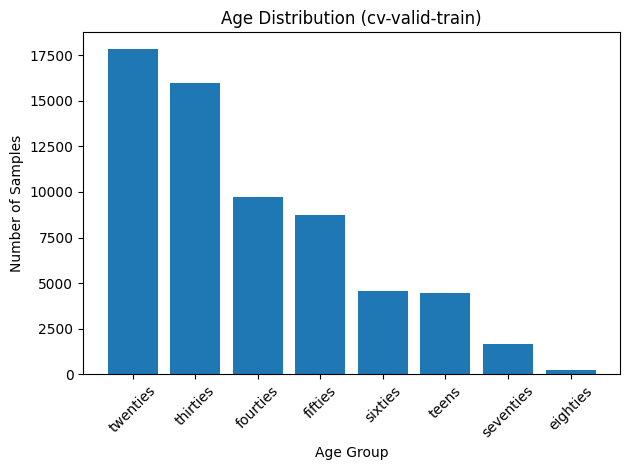

In [ ]:
age_pd = age_dist.toPandas()

import matplotlib.pyplot as plt

plt.figure()
plt.bar(age_pd["age"], age_pd["count"])
plt.xlabel("Age Group")
plt.ylabel("Number of Samples")
plt.title("Age Distribution (cv-valid-train)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
gender_dist = (
    df_train_clean
    .groupBy("gender")
    .count()
    .orderBy("count", ascending=False)
)

gender_dist.show()


+------+-----+
|gender|count|
+------+-----+
|  male|46002|
|female|16419|
| other|  742|
+------+-----+



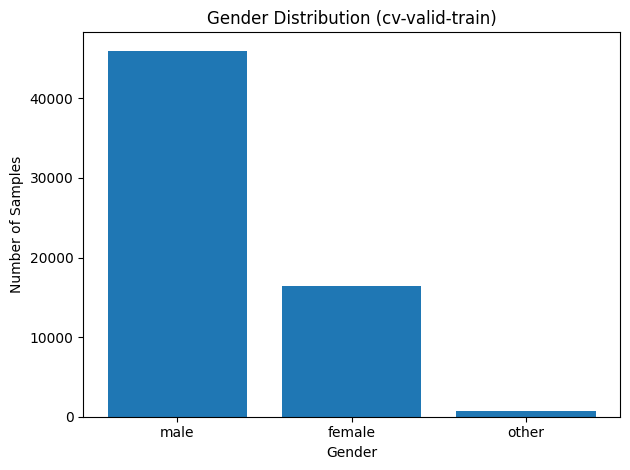

In [ ]:
gender_pd = gender_dist.toPandas()

plt.figure()
plt.bar(gender_pd["gender"], gender_pd["count"])
plt.xlabel("Gender")
plt.ylabel("Number of Samples")
plt.title("Gender Distribution (cv-valid-train)")
plt.tight_layout()
plt.show()


In [ ]:
accent_dist = (
    df_train_clean
    .groupBy("accent")
    .count()
    .orderBy("count", ascending=False)
)

accent_dist.show(10, truncate=False)


+-----------+-----+
|accent     |count|
+-----------+-----+
|us         |29926|
|england    |14875|
|indian     |4445 |
|australia  |4083 |
|canada     |3768 |
|scotland   |1556 |
|newzealand |1153 |
|african    |1149 |
|ireland    |944  |
|philippines|318  |
+-----------+-----+
only showing top 10 rows



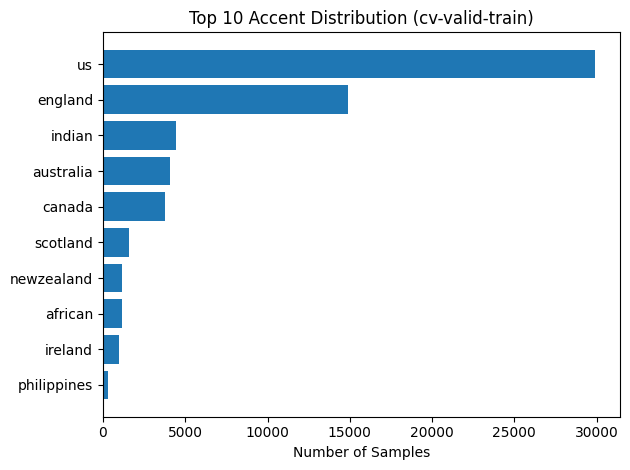

In [ ]:
accent_pd = accent_dist.limit(10).toPandas()

plt.figure()
plt.barh(accent_pd["accent"], accent_pd["count"])
plt.xlabel("Number of Samples")
plt.title("Top 10 Accent Distribution (cv-valid-train)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Grafiklere göre verileri  normalize etme
  - Yaş için az olan sınıfları bir üst sınıfla birleştirme
  - Cinsiyet için other sınıfını kaldırma
  - Aksan içinde
        - ❌ Model baskın aksanları öğrenir
        - ❌ Nadir aksanlarda aşırı overfitting
        - ❌ Accuracy yüksek, ama gerçek performans düşüktür

        bu yüzden burada Accent threshold’u uygulayarak bunun altında kalan aksanları dahil etmeyeceğim
             - N = 500 → dengeli
             - N = 1000 → güvenli

            olacaktır.

In [ ]:
from pyspark.sql.functions import col

accent_counts = (
    df_train_clean
    .groupBy("accent")
    .count()
    .orderBy("count", ascending=False)
)

accent_counts.show(truncate=False)


from pyspark.sql.functions import col

age_counts = (
    df_train_clean
    .groupBy("age")
    .count()
    .orderBy("count", ascending=False)
)

age_counts.show(truncate=False)

from pyspark.sql.functions import col

gender_counts = (
    df_train_clean
    .groupBy("gender")
    .count()
    .orderBy("count", ascending=False)
)

gender_counts.show(truncate=False)


+--------------+-----+
|accent        |count|
+--------------+-----+
|us            |29926|
|england       |14875|
|indian        |4445 |
|australia     |4083 |
|canada        |3768 |
|scotland      |1556 |
|newzealand    |1153 |
|african       |1149 |
|ireland       |944  |
|philippines   |318  |
|wales         |262  |
|bermuda       |196  |
|malaysia      |182  |
|singapore     |124  |
|hongkong      |99   |
|southatlandtic|83   |
+--------------+-----+

+---------+-----+
|age      |count|
+---------+-----+
|twenties |17874|
|thirties |15972|
|fourties |9732 |
|fifties  |8731 |
|sixties  |4549 |
|teens    |4435 |
|seventies|1631 |
|eighties |239  |
+---------+-----+

+------+-----+
|gender|count|
+------+-----+
|male  |46002|
|female|16419|
|other |742  |
+------+-----+



In [ ]:
MIN_SAMPLES = 1000

valid_accents = (
    accent_counts
    .filter(col("count") >= MIN_SAMPLES)
    .select("accent")
)


df_train_final = df_train_clean.join(
    valid_accents,
    on="accent",
    how="inner"
)

df_dev_final = df_dev_clean.join(
    valid_accents,
    on="accent",
    how="inner"
)

df_test_final = df_test_clean.join(
    valid_accents,
    on="accent",
    how="inner"
)
print("TRAIN:", df_train_clean.count(), "→", df_train_final.count())
print("DEV  :", df_dev_clean.count(),   "→", df_dev_final.count())
print("TEST :", df_test_clean.count(),  "→", df_test_final.count())

(
    df_train_final
    .groupBy("accent")
    .count()
    .orderBy("count", ascending=False)
    .show(truncate=False)
)


TRAIN: 63163 → 60955
DEV  : 1315 → 1278
TEST : 1320 → 1271
+----------+-----+
|accent    |count|
+----------+-----+
|us        |29926|
|england   |14875|
|indian    |4445 |
|australia |4083 |
|canada    |3768 |
|scotland  |1556 |
|newzealand|1153 |
|african   |1149 |
+----------+-----+



# Cinsiyet için normalize edelim


In [ ]:
from pyspark.sql.functions import col

df_train_gender_final = df_train_final.filter(
    col("gender").isin("male", "female")
)

df_dev_gender_final = df_dev_final.filter(
    col("gender").isin("male", "female")
)

df_test_gender_final = df_test_final.filter(
    col("gender").isin("male", "female")
)


In [ ]:
(
    df_train_gender_final
    .groupBy("gender")
    .count()
    .show()
)
print("TRAIN:", df_train_final.count(), "→", df_train_gender_final.count())
print("DEV  :", df_dev_final.count(),   "→", df_dev_gender_final.count())
print("TEST :", df_test_final.count(),  "→", df_test_gender_final.count())


+------+-----+
|gender|count|
+------+-----+
|female|15934|
|  male|44388|
+------+-----+

TRAIN: 60955 → 60322
DEV  : 1278 → 1270
TEST : 1271 → 1262


# Yaş için Normalizasyon yapalım

In [ ]:
from pyspark.sql.functions import when, col

df_train_age_final = (
    df_train_gender_final
    .withColumn(
        "age_group",
        when(col("age").isin("teens", "twenties", "thirties"), "young")
        .when(col("age").isin("fourties", "fifties"), "middle")
        .otherwise("senior")
    )
)

df_dev_age_final = (
    df_dev_gender_final
    .withColumn(
        "age_group",
        when(col("age").isin("teens", "twenties", "thirties"), "young")
        .when(col("age").isin("fourties", "fifties"), "middle")
        .otherwise("senior")
    )
)

df_test_age_final = (
    df_test_gender_final
    .withColumn(
        "age_group",
        when(col("age").isin("teens", "twenties", "thirties"), "young")
        .when(col("age").isin("fourties", "fifties"), "middle")
        .otherwise("senior")
    )
)


In [ ]:
(
    df_train_age_final
    .groupBy("age_group")
    .count()
    .orderBy("count", ascending=False)
    .show()
)


+---------+-----+
|age_group|count|
+---------+-----+
|    young|36177|
|   middle|17922|
|   senior| 6223|
+---------+-----+



# StringIndexer kullandığında:

Age → 0,1,2

Gender → 0,1

Accent → 0,1,2,... şeklinde etiketleri sayısal ve sabit hale getiriyoruz demektir.

In [ ]:
from pyspark.ml.feature import StringIndexer

# ⚠️ df_train_age_final kullanılmalı (age_group bu DataFrame'de var!)

# Age, gender, accent için indexer
age_indexer = StringIndexer(inputCol="age_group", outputCol="age_label").fit(df_train_age_final)
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_label").fit(df_train_age_final)
accent_indexer = StringIndexer(inputCol="accent", outputCol="accent_label").fit(df_train_age_final)

# Transform ve yeni kolonları ekle
df_train_labeled = age_indexer.transform(df_train_age_final)
df_train_labeled = gender_indexer.transform(df_train_labeled)
df_train_labeled = accent_indexer.transform(df_train_labeled)

df_dev_labeled = age_indexer.transform(df_dev_age_final)
df_dev_labeled = gender_indexer.transform(df_dev_labeled)
df_dev_labeled = accent_indexer.transform(df_dev_labeled)

df_test_labeled = age_indexer.transform(df_test_age_final)
df_test_labeled = gender_indexer.transform(df_test_labeled)
df_test_labeled = accent_indexer.transform(df_test_labeled)

# Artık Pandas'a çevirebilirsin
df_train_pd = df_train_labeled.toPandas()
df_dev_pd   = df_dev_labeled.toPandas()
df_test_pd  = df_test_labeled.toPandas()

print("✅ Label indexing tamamlandı!")

✅ Label indexing tamamlandı!


In [ ]:
df_train_pd

,accent,filename,text,up_votes,down_votes,age,gender,duration,age_group,age_label,gender_label,accent_label
0,us,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,None,young,0.0,1.0,0.0
1,us,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,None,senior,2.0,0.0,0.0
2,us,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,None,young,0.0,1.0,0.0
3,england,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,None,senior,2.0,0.0,1.0
4,australia,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,None,middle,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
60317,england,cv-valid-train/sample-195766.mp3,but before i go i want to tell you a little story,1,0,fourties,male,None,middle,1.0,0.0,1.0
60318,us,cv-valid-train/sample-195767.mp3,down below in the darkness were hundreds of pe...,3,0,thirties,female,None,young,0.0,1.0,0.0
60319,england,cv-valid-train/sample-195770.mp3,he heard a muffled grating sound and saw the b...,4,0,twenties,male,None,young,0.0,0.0,1.0
60320,england,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,None,young,0.0,0.0,1.0


In [ ]:
df_dev_pd

,accent,filename,text,up_votes,down_votes,age,gender,duration,age_group,age_label,gender_label,accent_label
0,us,cv-valid-dev/sample-004073.mp3,that's what i'm not supposed to say,2,0,thirties,male,None,young,0.0,0.0,0.0
1,us,cv-valid-dev/sample-004067.mp3,they reached the center of a large plaza where...,3,0,fourties,female,None,middle,1.0,1.0,0.0
2,us,cv-valid-dev/sample-004048.mp3,did you ever walk into this office,1,0,twenties,male,None,young,0.0,0.0,0.0
3,us,cv-valid-dev/sample-004045.mp3,i have to find a man who knows that universal ...,3,0,thirties,male,None,young,0.0,0.0,0.0
4,us,cv-valid-dev/sample-004040.mp3,they placed the symbols of the pilgrimage on t...,3,0,sixties,female,None,senior,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1265,newzealand,cv-valid-dev/sample-000846.mp3,and in that mood he was grateful to be in love,1,0,thirties,female,None,young,0.0,1.0,6.0
1266,newzealand,cv-valid-dev/sample-000819.mp3,then suddenly they kneel and die,3,0,thirties,male,None,young,0.0,0.0,6.0
1267,newzealand,cv-valid-dev/sample-000555.mp3,came to the bar he had entered on his first da...,2,0,fifties,female,None,middle,1.0,1.0,6.0
1268,newzealand,cv-valid-dev/sample-000445.mp3,and the odor of the animals became a bit more ...,1,0,fourties,male,None,middle,1.0,0.0,6.0


In [ ]:
keep_cols = [
    "filename",
    "age_group",
    "gender",
    "accent"
]

df_train_clean = df_train_age_final.select(*keep_cols)
df_dev_clean   = df_dev_age_final.select(*keep_cols)
df_test_clean  = df_test_age_final.select(*keep_cols)


In [ ]:
df_train_clean.printSchema()
df_train_clean.show(5, truncate=False)
df_dev_clean.show(5, truncate=False)
df_test_clean.show(5, truncate=False)

root
 |-- filename: string (nullable = true)
 |-- age_group: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- accent: string (nullable = true)

+--------------------------------+---------+------+---------+
|filename                        |age_group|gender|accent   |
+--------------------------------+---------+------+---------+
|cv-valid-train/sample-000005.mp3|young    |female|us       |
|cv-valid-train/sample-000008.mp3|senior   |male  |us       |
|cv-valid-train/sample-000013.mp3|young    |female|us       |
|cv-valid-train/sample-000014.mp3|senior   |male  |england  |
|cv-valid-train/sample-000019.mp3|middle   |male  |australia|
+--------------------------------+---------+------+---------+
only showing top 5 rows

+------------------------------+---------+------+------+
|filename                      |age_group|gender|accent|
+------------------------------+---------+------+------+
|cv-valid-dev/sample-004073.mp3|young    |male  |us    |
|cv-valid-dev/sample-0040

In [ ]:
df_dev_clean.select("filename").show(5, False)
df_test_clean.select("filename").show(5, False)


+------------------------------+
|filename                      |
+------------------------------+
|cv-valid-dev/sample-004073.mp3|
|cv-valid-dev/sample-004067.mp3|
|cv-valid-dev/sample-004048.mp3|
|cv-valid-dev/sample-004045.mp3|
|cv-valid-dev/sample-004040.mp3|
+------------------------------+
only showing top 5 rows

+-------------------------------+
|filename                       |
+-------------------------------+
|cv-valid-test/sample-003975.mp3|
|cv-valid-test/sample-003962.mp3|
|cv-valid-test/sample-003945.mp3|
|cv-valid-test/sample-003940.mp3|
|cv-valid-test/sample-003937.mp3|
+-------------------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
    StringIndexer(inputCol="age_group", outputCol="age_label"),
    StringIndexer(inputCol="gender", outputCol="gender_label"),
    StringIndexer(inputCol="accent", outputCol="accent_label")
])

pipeline_model = pipeline.fit(df_train_clean)
pipeline_model

PipelineModel_4bbc7caebb12

In [ ]:
df_train_labeled = pipeline_model.transform(df_train_clean)
df_dev_labeled   = pipeline_model.transform(df_dev_clean)
df_test_labeled  = pipeline_model.transform(df_test_clean)


In [ ]:
df_train_labeled.select("age_group", "age_label").distinct().show()
df_train_labeled.select("gender", "gender_label").distinct().show()
df_train_labeled.select("accent", "accent_label").distinct().show(20, False)


+---------+---------+
|age_group|age_label|
+---------+---------+
|    young|      0.0|
|   senior|      2.0|
|   middle|      1.0|
+---------+---------+

+------+------------+
|gender|gender_label|
+------+------------+
|female|         1.0|
|  male|         0.0|
+------+------------+

+----------+------------+
|accent    |accent_label|
+----------+------------+
|indian    |2.0         |
|scotland  |5.0         |
|african   |7.0         |
|us        |0.0         |
|canada    |4.0         |
|australia |3.0         |
|england   |1.0         |
|newzealand|6.0         |
+----------+------------+



# Ses Feature Extraction

In [ ]:
# 5 örnek al
samples = (
    df_train_clean
    .select("filename")
    .limit(5)
    .collect()
)

samples


[Row(filename='cv-valid-train/sample-000005.mp3'),
 Row(filename='cv-valid-train/sample-000008.mp3'),
 Row(filename='cv-valid-train/sample-000013.mp3'),
 Row(filename='cv-valid-train/sample-000014.mp3'),
 Row(filename='cv-valid-train/sample-000019.mp3')]

In [ ]:
import os

BASE_DIR = "/content/common-voice"

def build_full_path(rel_path):
    # rel_path: cv-valid-train/sample-000005.mp3
    split_dir = rel_path.split("/")[0]
    return os.path.join(BASE_DIR, split_dir, split_dir, rel_path.split("/")[1])


In [ ]:
for r in samples:
    full_path = build_full_path(r.filename)
    print(full_path, "→", os.path.exists(full_path))


/content/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3 → True
/content/common-voice/cv-valid-train/cv-valid-train/sample-000008.mp3 → True
/content/common-voice/cv-valid-train/cv-valid-train/sample-000013.mp3 → True
/content/common-voice/cv-valid-train/cv-valid-train/sample-000014.mp3 → True
/content/common-voice/cv-valid-train/cv-valid-train/sample-000019.mp3 → True


In [ ]:
import librosa

test_path = build_full_path(samples[0].filename)

y, sr = librosa.load(test_path, sr=16000)

print("Sample rate:", sr)
print("Duration (sec):", len(y) / sr)


Sample rate: 16000
Duration (sec): 5.832


In [ ]:
from IPython.display import Audio
Audio(test_path)


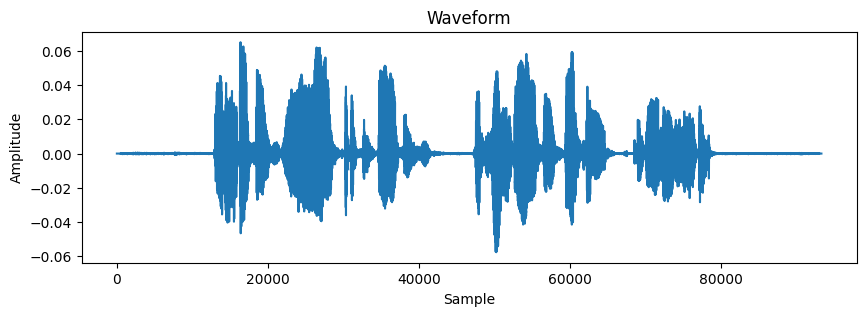

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(y)
plt.title("Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


#**Feature Extraction — Öznitelik Çıkarımı**

1.   Mel-Frekans Kepstral Katsayıları
2.   Zero Crossing Rate
3.   Spectral Centroid
4.   Spectral Rolloff
5.   Chroma Frekansı
6.   Spektral Bant Genişliği



**1.   Mel-Frekans Kepstral Katsayıları**

Mel-Frekans Kepstral Katsayıları (Mel-Frequency Cepstral Coefficients)

Mel frekans ölçeği, insan kulağının ses frekanslarındaki değişimi algılayışını gösteren bir ölçektir. MFCC(Mel-Frequency Cepstral Coefficients), ses sinyalinin kısa zamanlı güç spektrumunun Mel ölçeği üzerindeki ifadesidir.

Frekanstan Mel ölçeğine dönüşüm formülü;

M ═ 1125 × ln(1+(f÷700))

M → Mel ölçeği

f → Frekans(Hz)

In [ ]:
# =============================================================================
# FEATURE EXTRACTION - SPARK PANDAS UDF
# =============================================================================

import pandas as pd
import numpy as np
import librosa
from pyspark.sql.functions import pandas_udf, col, udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT

BASE_DIR = "/content/common-voice"

def build_full_path(rel_path):
    """Dosya yolunu tam path'e çevir"""
    split_dir = rel_path.split("/")[0]
    return f"{BASE_DIR}/{split_dir}/{split_dir}/{rel_path.split('/')[1]}"

@pandas_udf(ArrayType(FloatType()))
def extract_audio_features(file_paths: pd.Series) -> pd.Series:
    """
    Her ses dosyasından akustik özellikler çıkarır

    Çıkarılan özellikler (46 boyut):
    - MFCC mean (13)
    - MFCC std (13)
    - Zero Crossing Rate mean/std (2)
    - Spectral Centroid mean/std (2)
    - Spectral Rolloff mean/std (2)
    - Chroma mean (12)
    - Spectral Bandwidth mean/std (2)
    """
    import librosa
    import numpy as np

    results = []

    for path in file_paths:
        try:
            full_path = build_full_path(path)
            y, sr = librosa.load(full_path, sr=16000, duration=5)

            # Ses çok kısaysa padding yap
            if len(y) < sr:
                y = np.pad(y, (0, sr - len(y)))

            # 1. MFCC (13 katsayı)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc, axis=1).astype(np.float32)
            mfcc_std = np.std(mfcc, axis=1).astype(np.float32)

            # 2. Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y)
            zcr_mean = float(np.mean(zcr))
            zcr_std = float(np.std(zcr))

            # 3. Spectral Centroid
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            cent_mean = float(np.mean(cent))
            cent_std = float(np.std(cent))

            # 4. Spectral Rolloff
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            rolloff_mean = float(np.mean(rolloff))
            rolloff_std = float(np.std(rolloff))

            # 5. Chroma (12 frekans bandı)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chroma, axis=1).astype(np.float32)

            # 6. Spectral Bandwidth
            bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            bandwidth_mean = float(np.mean(bandwidth))
            bandwidth_std = float(np.std(bandwidth))

            # Tüm özellikleri birleştir (46 boyut)
            features = np.concatenate([
                mfcc_mean,                          # 13
                mfcc_std,                           # 13
                [zcr_mean, zcr_std],                # 2
                [cent_mean, cent_std],              # 2
                [rolloff_mean, rolloff_std],        # 2
                chroma_mean,                        # 12
                [bandwidth_mean, bandwidth_std]     # 2
            ]).tolist()

            results.append(features)

        except Exception as e:
            # Hata durumunda sıfır vektör döndür
            results.append([0.0] * 46)

    return pd.Series(results)

print("✅ Feature extraction fonksiyonu tanımlandı!")
print("📊 Çıkarılacak özellikler:")
print("   - MFCC (mean + std): 26 boyut")
print("   - Zero Crossing Rate: 2 boyut")
print("   - Spectral Centroid: 2 boyut")
print("   - Spectral Rolloff: 2 boyut")
print("   - Chroma: 12 boyut")
print("   - Spectral Bandwidth: 2 boyut")
print("   - TOPLAM: 46 boyut")


✅ Feature extraction fonksiyonu tanımlandı!
📊 Çıkarılacak özellikler:
   - MFCC (mean + std): 26 boyut
   - Zero Crossing Rate: 2 boyut
   - Spectral Centroid: 2 boyut
   - Spectral Rolloff: 2 boyut
   - Chroma: 12 boyut
   - Spectral Bandwidth: 2 boyut
   - TOPLAM: 46 boyut


In [ ]:
# =============================================================================
# FEATURE EXTRACTION UYGULA
# =============================================================================

import time

print("🎵 Feature extraction başlıyor...")
print(f"   Train: {df_train_labeled.count()} örnek")
print(f"   Dev: {df_dev_labeled.count()} örnek")
print(f"   Test: {df_test_labeled.count()} örnek")

start_time = time.time()

# Feature extraction uygula
df_train_features = df_train_labeled.withColumn(
    "audio_features",
    extract_audio_features(col("filename"))
)

df_dev_features = df_dev_labeled.withColumn(
    "audio_features",
    extract_audio_features(col("filename"))
)

df_test_features = df_test_labeled.withColumn(
    "audio_features",
    extract_audio_features(col("filename"))
)

# Cache'le (lazy evaluation olduğu için count ile tetikle)
df_train_features = df_train_features.cache()
df_dev_features = df_dev_features.cache()
df_test_features = df_test_features.cache()

train_count = df_train_features.count()
dev_count = df_dev_features.count()
test_count = df_test_features.count()

elapsed = time.time() - start_time
print(f"\n✅ Feature extraction tamamlandı!")
print(f"⏱️  Süre: {elapsed/60:.1f} dakika")
print(f"📊 Train: {train_count}, Dev: {dev_count}, Test: {test_count}")


🎵 Feature extraction başlıyor...
   Train: 60322 örnek
   Dev: 1270 örnek
   Test: 1262 örnek

✅ Feature extraction tamamlandı!
⏱️  Süre: 55.6 dakika
📊 Train: 60322, Dev: 1270, Test: 1262


In [ ]:
# =============================================================================
# ARRAY'İ SPARK ML VECTOR'E DÖNÜŞTÜR
# =============================================================================

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

# Array'i Vector'e çeviren UDF
array_to_vector = udf(lambda arr: Vectors.dense(arr) if arr else Vectors.dense([0.0]*46), VectorUDT())

df_train_vec = df_train_features.withColumn("features_raw", array_to_vector(col("audio_features")))
df_dev_vec = df_dev_features.withColumn("features_raw", array_to_vector(col("audio_features")))
df_test_vec = df_test_features.withColumn("features_raw", array_to_vector(col("audio_features")))

print("✅ Features vektöre dönüştürüldü!")
df_train_vec.select("filename", "features_raw").show(3, truncate=50)


✅ Features vektöre dönüştürüldü!
+--------------------------------+--------------------------------------------------+
|                        filename|                                      features_raw|
+--------------------------------+--------------------------------------------------+
|cv-valid-train/sample-000005.mp3|[-524.77197265625,75.91769409179688,25.65176200...|
|cv-valid-train/sample-000008.mp3|[-390.6391906738281,86.6077880859375,-31.042064...|
|cv-valid-train/sample-000013.mp3|[-324.16510009765625,67.61723327636719,-48.6213...|
+--------------------------------+--------------------------------------------------+
only showing top 3 rows



In [ ]:
# =============================================================================
# FEATURE NORMALIZATION (StandardScaler)
# =============================================================================

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_train_vec)

df_train_scaled = scaler_model.transform(df_train_vec)
df_dev_scaled = scaler_model.transform(df_dev_vec)
df_test_scaled = scaler_model.transform(df_test_vec)

print("✅ Features normalize edildi!")
df_train_scaled.select("filename", "features").show(3, truncate=50)


✅ Features normalize edildi!
+--------------------------------+--------------------------------------------------+
|                        filename|                                          features|
+--------------------------------+--------------------------------------------------+
|cv-valid-train/sample-000005.mp3|[-1.6759775202893203,-0.13876851717273148,1.345...|
|cv-valid-train/sample-000008.mp3|[-0.27475805921600144,0.2522751419313605,-1.867...|
|cv-valid-train/sample-000013.mp3|[0.419664199055576,-0.442399389950356,-2.863839...|
+--------------------------------+--------------------------------------------------+
only showing top 3 rows



In [ ]:
# =============================================================================
# VERİ SETİNİ KONTROL ET
# =============================================================================

print("📊 Final veri seti yapısı:")
df_train_scaled.printSchema()

print("\n📊 Label dağılımları:")
print("\n🔹 Age:")
df_train_scaled.groupBy("age_label").count().orderBy("age_label").show()

print("🔹 Gender:")
df_train_scaled.groupBy("gender_label").count().orderBy("gender_label").show()

print("🔹 Accent:")
df_train_scaled.groupBy("accent_label").count().orderBy("accent_label").show()

print("\n✅ Veri model eğitimine hazır!")
print("   - features: 46 boyutlu normalize edilmiş özellik vektörü")
print("   - age_label: Yaş etiketi (0=young, 1=middle, 2=senior)")
print("   - gender_label: Cinsiyet etiketi (0=male, 1=female)")
print("   - accent_label: Aksan etiketi (0-7 arası)")


📊 Final veri seti yapısı:
root
 |-- filename: string (nullable = true)
 |-- age_group: string (nullable = false)
 |-- gender: string (nullable = true)
 |-- accent: string (nullable = true)
 |-- age_label: double (nullable = false)
 |-- gender_label: double (nullable = false)
 |-- accent_label: double (nullable = false)
 |-- audio_features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_raw: vector (nullable = true)
 |-- features: vector (nullable = true)


📊 Label dağılımları:

🔹 Age:
+---------+-----+
|age_label|count|
+---------+-----+
|      0.0|36177|
|      1.0|17922|
|      2.0| 6223|
+---------+-----+

🔹 Gender:
+------------+-----+
|gender_label|count|
+------------+-----+
|         0.0|44388|
|         1.0|15934|
+------------+-----+

🔹 Accent:
+------------+-----+
|accent_label|count|
+------------+-----+
|         0.0|29555|
|         1.0|14704|
|         2.0| 4445|
|         3.0| 4076|
|         4.0| 3760|
|         5.0| 1480|
|        

In [ ]:
# =============================================================================
# 🚨 ÖNEMLİ: VERİLERİ GOOGLE DRIVE'A KAYDET (Kaybolmasın!)
# =============================================================================

import os

SAVE_PATH = "/content/drive/MyDrive/cv_features"
os.makedirs(SAVE_PATH, exist_ok=True)

print("💾 Veriler Google Drive'a kaydediliyor...")

# Spark DataFrame'leri Parquet olarak kaydet
df_train_scaled.write.mode("overwrite").parquet(f"{SAVE_PATH}/train_features.parquet")
df_dev_scaled.write.mode("overwrite").parquet(f"{SAVE_PATH}/dev_features.parquet")
df_test_scaled.write.mode("overwrite").parquet(f"{SAVE_PATH}/test_features.parquet")

print("✅ Veriler başarıyla kaydedildi!")
print(f"📁 Konum: {SAVE_PATH}")
print("   - train_features.parquet")
print("   - dev_features.parquet")
print("   - test_features.parquet")
print("\n⚠️ Artık runtime çökse bile veriler güvende!")


💾 Veriler Google Drive'a kaydediliyor...
✅ Veriler başarıyla kaydedildi!
📁 Konum: /content/drive/MyDrive/cv_features
   - train_features.parquet
   - dev_features.parquet
   - test_features.parquet

⚠️ Artık runtime çökse bile veriler güvende!


In [ ]:
# =============================================================================
# MODEL EĞİTİMİ - SKLEARN İLE (Daha Stabil)
# =============================================================================
# Spark bellek sorunları yaşadığı için sklearn kullanıyoruz
# Veriler zaten kaydedildi, şimdi Pandas ile okuyup eğitim yapacağız

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

print("=" * 60)
print("📦 VERİLERİ PANDAS'A DÖNÜŞTÜR")
print("=" * 60)

# Spark DataFrame'den Pandas'a çevir
print("📌 Train verisi dönüştürülüyor...")
df_train_pd = df_train_scaled.toPandas()
print("📌 Test verisi dönüştürülüyor...")
df_test_pd = df_test_scaled.toPandas()

# Features'ı numpy array'e çevir
X_train = np.array(df_train_pd["features"].tolist())
X_test = np.array(df_test_pd["features"].tolist())

# Labels
y_train_gender = df_train_pd["gender_label"].values
y_test_gender = df_test_pd["gender_label"].values

y_train_age = df_train_pd["age_label"].values
y_test_age = df_test_pd["age_label"].values

y_train_accent = df_train_pd["accent_label"].values
y_test_accent = df_test_pd["accent_label"].values

print(f"\n✅ Dönüştürme tamamlandı!")
print(f"   Train: {X_train.shape}")
print(f"   Test: {X_test.shape}")


📦 VERİLERİ PANDAS'A DÖNÜŞTÜR
📌 Train verisi dönüştürülüyor...
📌 Test verisi dönüştürülüyor...

✅ Dönüştürme tamamlandı!
   Train: (60322, 46)
   Test: (1262, 46)


In [ ]:
# =============================================================================
# GENDER (CİNSİYET) SINIFLANDIRMA
# =============================================================================

print("=" * 60)
print("🎯 GENDER (CİNSİYET) SINIFLANDIRMA")
print("=" * 60)

# -------------------- RandomForest --------------------
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_gender = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_gender.fit(X_train, y_train_gender)
rf_gender_time = time.time() - start_time

y_pred_rf_gender = rf_gender.predict(X_test)
rf_acc_gender = accuracy_score(y_test_gender, y_pred_rf_gender)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_gender:.4f}, Süre: {rf_gender_time:.1f}s")

# -------------------- SVM RBF --------------------
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_gender = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_gender.fit(X_train, y_train_gender)
svm_gender_time = time.time() - start_time

y_pred_svm_gender = svm_gender.predict(X_test)
svm_acc_gender = accuracy_score(y_test_gender, y_pred_svm_gender)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_gender:.4f}, Süre: {svm_gender_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Gender):")
print(classification_report(y_test_gender, y_pred_svm_gender, target_names=["male", "female"]))


🎯 GENDER (CİNSİYET) SINIFLANDIRMA

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.8590, Süre: 5.5s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.9588, Süre: 102.6s

📊 SVM RBF Classification Report (Gender):
              precision    recall  f1-score   support

        male       0.96      0.98      0.97       918
      female       0.96      0.89      0.92       344

    accuracy                           0.96      1262
   macro avg       0.96      0.94      0.95      1262
weighted avg       0.96      0.96      0.96      1262



In [ ]:
# =============================================================================
# AGE (YAŞ) SINIFLANDIRMA
# =============================================================================

print("=" * 60)
print("🎯 AGE (YAŞ) SINIFLANDIRMA")
print("   0=young, 1=middle, 2=senior")
print("=" * 60)

# -------------------- RandomForest --------------------
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_age = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_age.fit(X_train, y_train_age)
rf_age_time = time.time() - start_time

y_pred_rf_age = rf_age.predict(X_test)
rf_acc_age = accuracy_score(y_test_age, y_pred_rf_age)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_age:.4f}, Süre: {rf_age_time:.1f}s")

# -------------------- SVM RBF --------------------
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_age = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_age.fit(X_train, y_train_age)
svm_age_time = time.time() - start_time

y_pred_svm_age = svm_age.predict(X_test)
svm_acc_age = accuracy_score(y_test_age, y_pred_svm_age)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_age:.4f}, Süre: {svm_age_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Age):")
print(classification_report(y_test_age, y_pred_svm_age, target_names=["young", "middle", "senior"]))


🎯 AGE (YAŞ) SINIFLANDIRMA
   0=young, 1=middle, 2=senior

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.6561, Süre: 6.0s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.8447, Süre: 252.2s

📊 SVM RBF Classification Report (Age):
              precision    recall  f1-score   support

       young       0.82      0.97      0.89       759
      middle       0.90      0.65      0.76       380
      senior       0.96      0.69      0.80       123

    accuracy                           0.84      1262
   macro avg       0.89      0.77      0.81      1262
weighted avg       0.86      0.84      0.84      1262



In [ ]:
# =============================================================================
# ACCENT (AKSAN) SINIFLANDIRMA
# =============================================================================

print("=" * 60)
print("🎯 ACCENT (AKSAN) SINIFLANDIRMA")
print("   8 farklı aksan")
print("=" * 60)

accent_names = ["us", "england", "indian", "australia", "canada", "scotland", "newzealand", "african"]

# -------------------- RandomForest --------------------
print("\n📌 RandomForest eğitiliyor...")
start_time = time.time()
rf_accent = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf_accent.fit(X_train, y_train_accent)
rf_accent_time = time.time() - start_time

y_pred_rf_accent = rf_accent.predict(X_test)
rf_acc_accent = accuracy_score(y_test_accent, y_pred_rf_accent)
print(f"   ✅ RandomForest - Accuracy: {rf_acc_accent:.4f}, Süre: {rf_accent_time:.1f}s")

# -------------------- SVM RBF --------------------
print("\n📌 SVM RBF eğitiliyor...")
start_time = time.time()
svm_accent = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_accent.fit(X_train, y_train_accent)
svm_accent_time = time.time() - start_time

y_pred_svm_accent = svm_accent.predict(X_test)
svm_acc_accent = accuracy_score(y_test_accent, y_pred_svm_accent)
print(f"   ✅ SVM RBF - Accuracy: {svm_acc_accent:.4f}, Süre: {svm_accent_time:.1f}s")

# Classification Report
print("\n📊 SVM RBF Classification Report (Accent):")
print(classification_report(y_test_accent, y_pred_svm_accent, target_names=accent_names))


🎯 ACCENT (AKSAN) SINIFLANDIRMA
   8 farklı aksan

📌 RandomForest eğitiliyor...
   ✅ RandomForest - Accuracy: 0.5959, Süre: 6.7s

📌 SVM RBF eğitiliyor...
   ✅ SVM RBF - Accuracy: 0.7845, Süre: 291.9s

📊 SVM RBF Classification Report (Accent):
              precision    recall  f1-score   support

          us       0.74      0.96      0.83       618
     england       0.81      0.73      0.77       294
      indian       0.92      0.66      0.77        90
   australia       0.96      0.50      0.66        90
      canada       0.98      0.41      0.58        99
    scotland       0.90      0.58      0.71        31
  newzealand       1.00      0.50      0.67        16
     african       1.00      0.54      0.70        24

    accuracy                           0.78      1262
   macro avg       0.91      0.61      0.71      1262
weighted avg       0.81      0.78      0.77      1262



In [ ]:
# =============================================================================
# SONUÇ ÖZETİ - TÜM MODELLER
# =============================================================================

print("=" * 70)
print("📊 TÜM MODEL SONUÇLARI - KARŞILAŞTIRMA")
print("=" * 70)

print("\n🎯 GENDER (Cinsiyet) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_gender:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_gender:<12.4f}")

print("\n🎯 AGE (Yaş) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_age:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_age:<12.4f}")

print("\n🎯 ACCENT (Aksan) Sınıflandırma:")
print(f"   {'Model':<20} {'Accuracy':<12}")
print(f"   {'-'*32}")
print(f"   {'RandomForest':<20} {rf_acc_accent:<12.4f}")
print(f"   {'SVM RBF':<20} {svm_acc_accent:<12.4f}")

print("\n" + "=" * 70)
print("✅ Tüm modeller başarıyla eğitildi ve değerlendirildi!")
print("=" * 70)


📊 TÜM MODEL SONUÇLARI - KARŞILAŞTIRMA

🎯 GENDER (Cinsiyet) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.8590      
   SVM RBF              0.9588      

🎯 AGE (Yaş) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.6561      
   SVM RBF              0.8447      

🎯 ACCENT (Aksan) Sınıflandırma:
   Model                Accuracy    
   --------------------------------
   RandomForest         0.5959      
   SVM RBF              0.7845      

✅ Tüm modeller başarıyla eğitildi ve değerlendirildi!


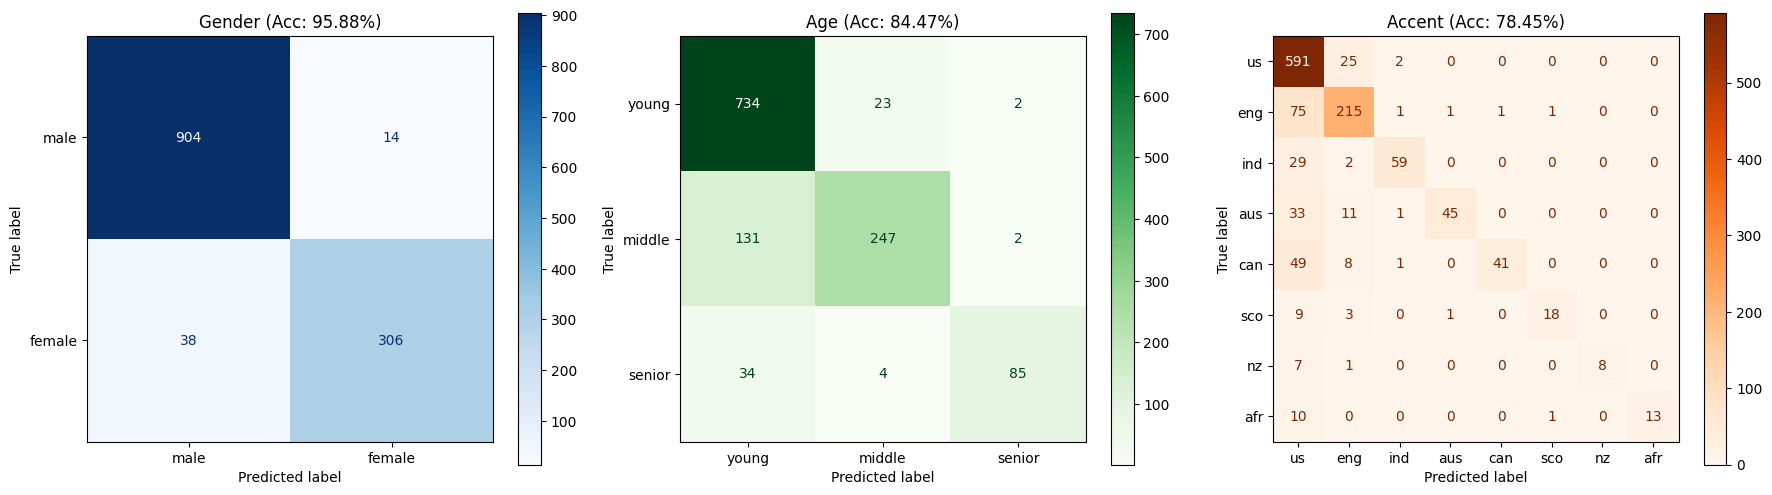


✅ Confusion matrix görseli kaydedildi: /content/drive/MyDrive/confusion_matrices.png


In [ ]:
# =============================================================================
# CONFUSION MATRIX GÖRSELLEŞTİRME
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gender Confusion Matrix
cm_gender = confusion_matrix(y_test_gender, y_pred_svm_gender)
disp_gender = ConfusionMatrixDisplay(confusion_matrix=cm_gender, display_labels=["male", "female"])
disp_gender.plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title(f"Gender (Acc: {svm_acc_gender:.2%})")

# Age Confusion Matrix
cm_age = confusion_matrix(y_test_age, y_pred_svm_age)
disp_age = ConfusionMatrixDisplay(confusion_matrix=cm_age, display_labels=["young", "middle", "senior"])
disp_age.plot(ax=axes[1], cmap=plt.cm.Greens)
axes[1].set_title(f"Age (Acc: {svm_acc_age:.2%})")

# Accent Confusion Matrix
cm_accent = confusion_matrix(y_test_accent, y_pred_svm_accent)
accent_short = ["us", "eng", "ind", "aus", "can", "sco", "nz", "afr"]
disp_accent = ConfusionMatrixDisplay(confusion_matrix=cm_accent, display_labels=accent_short)
disp_accent.plot(ax=axes[2], cmap=plt.cm.Oranges)
axes[2].set_title(f"Accent (Acc: {svm_acc_accent:.2%})")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/confusion_matrices.png", dpi=150)
plt.show()

print("\n✅ Confusion matrix görseli kaydedildi: /content/drive/MyDrive/confusion_matrices.png")


In [ ]:
# =============================================================================
# MODELLERİ KAYDET
# =============================================================================

import joblib

MODEL_PATH = "/content/drive/MyDrive/common_voice_models"
os.makedirs(MODEL_PATH, exist_ok=True)

# sklearn modelleri kaydet
joblib.dump(rf_gender, f"{MODEL_PATH}/rf_gender.pkl")
joblib.dump(rf_age, f"{MODEL_PATH}/rf_age.pkl")
joblib.dump(rf_accent, f"{MODEL_PATH}/rf_accent.pkl")

joblib.dump(svm_gender, f"{MODEL_PATH}/svm_gender.pkl")
joblib.dump(svm_age, f"{MODEL_PATH}/svm_age.pkl")
joblib.dump(svm_accent, f"{MODEL_PATH}/svm_accent.pkl")

print("✅ Tüm modeller kaydedildi!")
print(f"\n📁 Kayıt yeri: {MODEL_PATH}")
print("\n   RandomForest Modelleri:")
print("   - rf_gender.pkl")
print("   - rf_age.pkl")
print("   - rf_accent.pkl")
print("\n   SVM RBF Modelleri:")
print("   - svm_gender.pkl")
print("   - svm_age.pkl")
print("   - svm_accent.pkl")


✅ Tüm modeller kaydedildi!

📁 Kayıt yeri: /content/drive/MyDrive/common_voice_models

   RandomForest Modelleri:
   - rf_gender.pkl
   - rf_age.pkl
   - rf_accent.pkl

   SVM RBF Modelleri:
   - svm_gender.pkl
   - svm_age.pkl
   - svm_accent.pkl


In [ ]:
import numpy as np

# Tüm tahminleri ve gerçek değerleri numpy array’e çevir
y_true_combined = np.column_stack([y_test_gender, y_test_age, y_test_accent])
y_pred_combined = np.column_stack([y_pred_svm_gender, y_pred_svm_age, y_pred_svm_accent])

# Satır bazında tüm etiketlerin doğru olup olmadığını kontrol et
correct_multi_label = np.all(y_true_combined == y_pred_combined, axis=1)

# Multi-label accuracy
multi_label_acc = np.mean(correct_multi_label)
print(f"🔹 Multi-label Accuracy (Gender + Age + Accent): {multi_label_acc:.2%}")


🔹 Multi-label Accuracy (Gender + Age + Accent): 66.96%


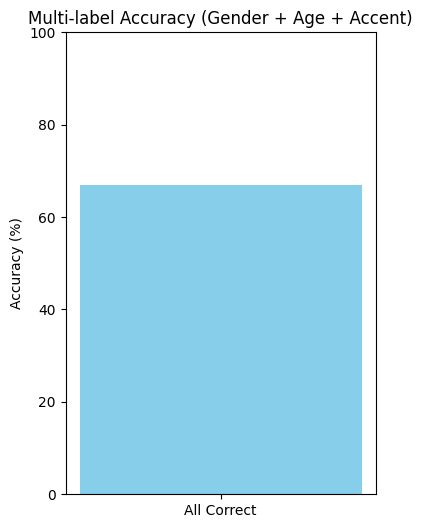

In [ ]:
import matplotlib.pyplot as plt

# Multi-label doğruluk
labels = ['All Correct']
values = [multi_label_acc * 100]

plt.figure(figsize=(4,6))
plt.bar(labels, values, color='skyblue')
plt.ylim(0,100)
plt.ylabel("Accuracy (%)")
plt.title("Multi-label Accuracy (Gender + Age + Accent)")
plt.show()


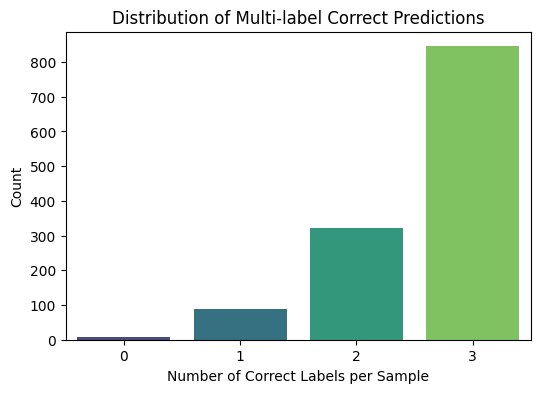

In [ ]:
import seaborn as sns
import pandas as pd

# Tüm gerçek ve tahminleri dataframe yapalım
df = pd.DataFrame({
    'gender_true': y_test_gender,
    'age_true': y_test_age,
    'accent_true': y_test_accent,
    'gender_pred': y_pred_svm_gender,
    'age_pred': y_pred_svm_age,
    'accent_pred': y_pred_svm_accent
})

# Her satır için kaç etiketin doğru olduğunu say
df['correct_count'] = (df['gender_true'] == df['gender_pred']).astype(int) + \
                      (df['age_true'] == df['age_pred']).astype(int) + \
                      (df['accent_true'] == df['accent_pred']).astype(int)

# Count plot
plt.figure(figsize=(6,4))
sns.countplot(x='correct_count', data=df, palette='viridis')
plt.xlabel("Number of Correct Labels per Sample")
plt.ylabel("Count")
plt.title("Distribution of Multi-label Correct Predictions")
plt.show()


🔹 Multi-label Accuracy (Gender + Age + Accent): 66.96%


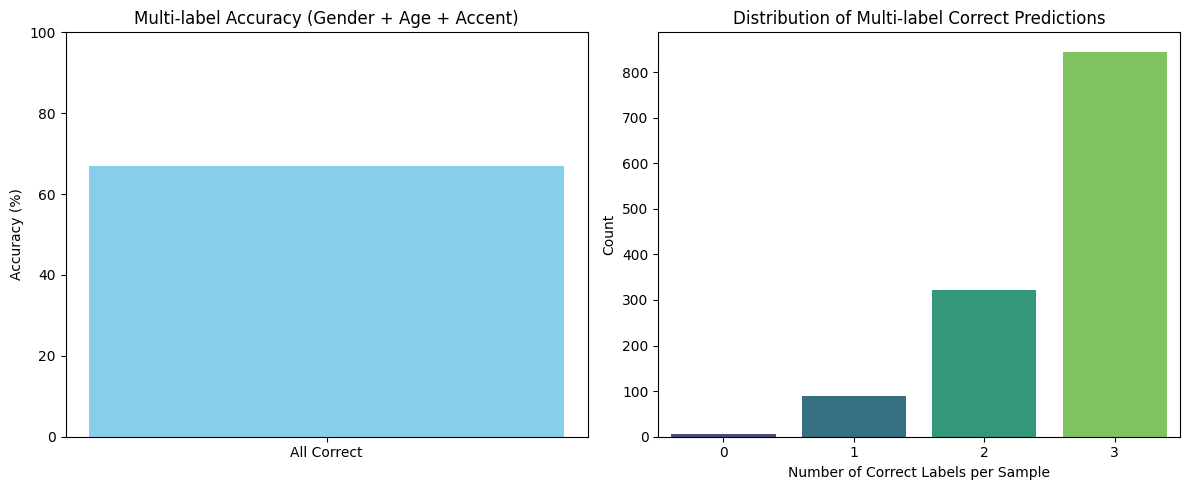

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Multi-label doğruluk hesaplama
# ---------------------------------------------------------------------
y_true_combined = np.column_stack([y_test_gender, y_test_age, y_test_accent])
y_pred_combined = np.column_stack([y_pred_svm_gender, y_pred_svm_age, y_pred_svm_accent])

# Her satır için tüm etiketlerin doğru olup olmadığını kontrol et
correct_multi_label = np.all(y_true_combined == y_pred_combined, axis=1)
multi_label_acc = np.mean(correct_multi_label)

print(f"🔹 Multi-label Accuracy (Gender + Age + Accent): {multi_label_acc:.2%}")

# ---------------------------------------------------------------------
# Count plot için dataframe
# ---------------------------------------------------------------------
df = pd.DataFrame({
    'gender_true': y_test_gender,
    'age_true': y_test_age,
    'accent_true': y_test_accent,
    'gender_pred': y_pred_svm_gender,
    'age_pred': y_pred_svm_age,
    'accent_pred': y_pred_svm_accent
})

# Her satır için kaç etiket doğru
df['correct_count'] = (df['gender_true'] == df['gender_pred']).astype(int) + \
                      (df['age_true'] == df['age_pred']).astype(int) + \
                      (df['accent_true'] == df['accent_pred']).astype(int)

# ---------------------------------------------------------------------
# Görselleştirme
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# 1️⃣ Multi-label accuracy bar grafiği
axes[0].bar(['All Correct'], [multi_label_acc*100], color='skyblue')
axes[0].set_ylim(0,100)
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Multi-label Accuracy (Gender + Age + Accent)")

# 2️⃣ Etiket doğruluk dağılımı
sns.countplot(x='correct_count', data=df, palette='viridis', ax=axes[1])
axes[1].set_xlabel("Number of Correct Labels per Sample")
axes[1].set_ylabel("Count")
axes[1].set_title("Distribution of Multi-label Correct Predictions")

plt.tight_layout()
plt.show()


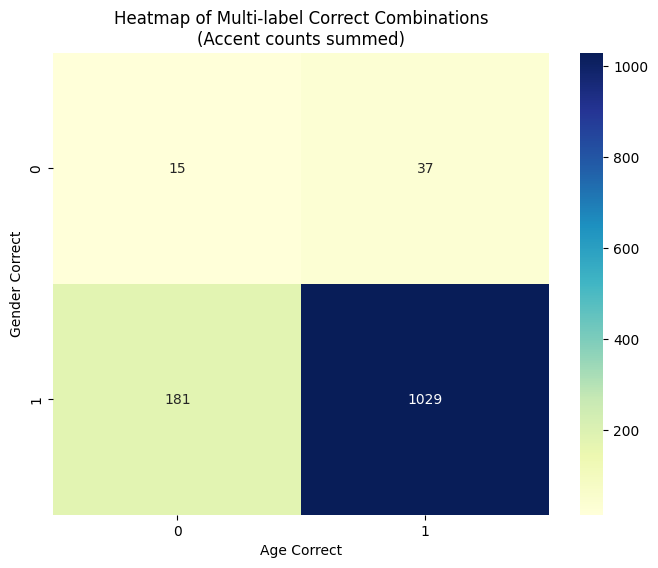

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

# ---------------------------------------------------------------------
# Her etiket için doğru/yanlış (1=doğru, 0=yanlış)
# ---------------------------------------------------------------------
df_comb = pd.DataFrame({
    'gender_correct': (y_test_gender == y_pred_svm_gender).astype(int),
    'age_correct': (y_test_age == y_pred_svm_age).astype(int),
    'accent_correct': (y_test_accent == y_pred_svm_accent).astype(int)
})

# ---------------------------------------------------------------------
# Kombinasyonları string olarak etiketle
# ---------------------------------------------------------------------
df_comb['combo'] = df_comb.apply(lambda row: f"{row['gender_correct']}{row['age_correct']}{row['accent_correct']}", axis=1)

# Kombinasyonların frekansını say
combo_counts = df_comb['combo'].value_counts().sort_index()

# Tüm olası kombinasyonlar (000, 001, ..., 111)
all_combos = [''.join(map(str, x)) for x in product([0,1], repeat=3)]
combo_counts = combo_counts.reindex(all_combos, fill_value=0)

# ---------------------------------------------------------------------
# Heatmap için dataframe
# ---------------------------------------------------------------------
heatmap_df = pd.DataFrame([list(map(int, list(k))) + [v] for k,v in combo_counts.items()],
                          columns=['gender','age','accent','count'])

# Pivot table ile 2D heatmap (gender vs age, accent ile renk)
heatmap_pivot = heatmap_df.pivot_table(index='gender', columns='age', values='count', aggfunc='sum')

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Age Correct")
plt.ylabel("Gender Correct")
plt.title("Heatmap of Multi-label Correct Combinations\n(Accent counts summed)")
plt.show()


🔹 Multi-label Accuracy (Gender + Age + Accent): 66.96%


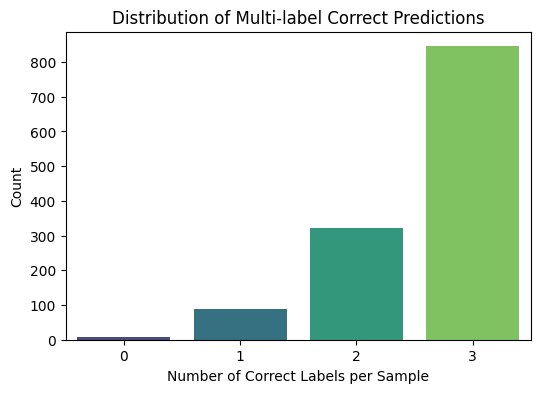

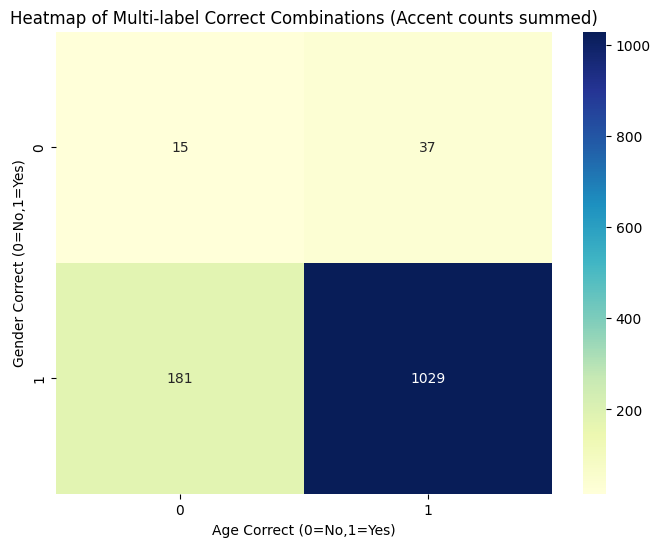

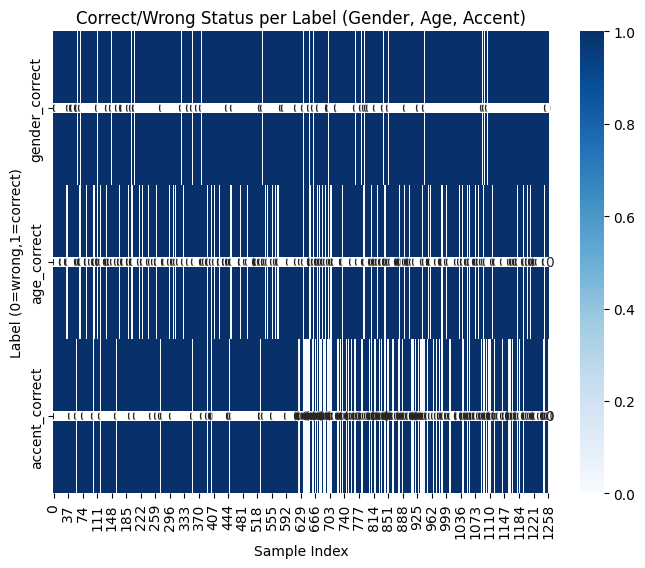

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# --------------------------------------------------
# 1️⃣ Her etiket için doğru/yanlış (1=doğru, 0=yanlış)
# --------------------------------------------------
df = pd.DataFrame({
    'gender_correct': (y_test_gender == y_pred_svm_gender).astype(int),
    'age_correct': (y_test_age == y_pred_svm_age).astype(int),
    'accent_correct': (y_test_accent == y_pred_svm_accent).astype(int)
})

# --------------------------------------------------
# 2️⃣ Multi-label Accuracy
# --------------------------------------------------
df['all_correct'] = df.all(axis=1)
multi_label_acc = df['all_correct'].mean()
print(f"🔹 Multi-label Accuracy (Gender + Age + Accent): {multi_label_acc:.2%}")

# --------------------------------------------------
# 3️⃣ Kaç etiket doğru dağılımı
# --------------------------------------------------
df['correct_count'] = df[['gender_correct','age_correct','accent_correct']].sum(axis=1)
plt.figure(figsize=(6,4))
sns.countplot(x='correct_count', data=df, palette='viridis')
plt.xlabel("Number of Correct Labels per Sample")
plt.ylabel("Count")
plt.title("Distribution of Multi-label Correct Predictions")
plt.show()

# --------------------------------------------------
# 4️⃣ Heatmap: Tüm kombinasyonların sayısı
# --------------------------------------------------
# Kombinasyonları string olarak etiketle
df['combo'] = df.apply(lambda row: f"{row['gender_correct']}{row['age_correct']}{row['accent_correct']}", axis=1)
combo_counts = df['combo'].value_counts().sort_index()
all_combos = [''.join(map(str, x)) for x in product([0,1], repeat=3)]
combo_counts = combo_counts.reindex(all_combos, fill_value=0)

# Heatmap dataframe (gender vs age, accent ile renk)
heatmap_df = pd.DataFrame([list(map(int,list(k))) + [v] for k,v in combo_counts.items()],
                          columns=['gender','age','accent','count'])
heatmap_pivot = heatmap_df.pivot_table(index='gender', columns='age', values='count', aggfunc='sum')

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Age Correct (0=No,1=Yes)")
plt.ylabel("Gender Correct (0=No,1=Yes)")
plt.title("Heatmap of Multi-label Correct Combinations (Accent counts summed)")
plt.show()

# --------------------------------------------------
# 5️⃣ 3D Lokasyon Heatmap (Accent dahil)
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df[['gender_correct','age_correct','accent_correct']].T, cmap='Blues', cbar=True, annot=True)
ax.set_xlabel("Sample Index")
ax.set_ylabel("Label (0=wrong,1=correct)")
ax.set_title("Correct/Wrong Status per Label (Gender, Age, Accent)")
plt.show()


# Benchmark kaydedelim ray ile kıyas yapabilmek için

In [ ]:
# =============================================================================
# 📊 SPARK BENCHMARK SONUÇLARINI KAYDET (Ray ile karşılaştırma için)
# =============================================================================

import json
import os
from datetime import datetime

BENCHMARK_PATH = "/content/drive/MyDrive/spark_colabratory_2/benchmark"
os.makedirs(BENCHMARK_PATH, exist_ok=True)

# Spark feature extraction süresi (Cell 73 çıktısından)
SPARK_FE_TIME = 55.6  # dakika

spark_benchmark = {
    "framework": "Spark",
    "timestamp": datetime.now().isoformat(),
    "system": {
        "cpu_count": 12,  # Colab Pro+ A100
        "ram_gb": 167.1,
        "colab_type": "Colab Pro+ (High-RAM)"
    },
    "feature_extraction": {
        "train_samples": 60322,
        "test_samples": 1262,
        "train_time_minutes": SPARK_FE_TIME,
        "test_time_minutes": 0,  # Test ayrı ölçülmedi
        "total_time_minutes": SPARK_FE_TIME
    },
    "status": "completed",
    "crashed": False
}

# JSON olarak kaydet
with open(f"{BENCHMARK_PATH}/spark_benchmark.json", 'w') as f:
    json.dump(spark_benchmark, f, indent=2)

print("✅ Spark benchmark kaydedildi!")
print(f"📁 Konum: {BENCHMARK_PATH}/spark_benchmark.json")
print(f"\n📊 Kaydedilen bilgiler:")
print(f"   Framework: {spark_benchmark['framework']}")
print(f"   FE Süresi: {spark_benchmark['feature_extraction']['total_time_minutes']} dakika")
print(f"   Train örnekleri: {spark_benchmark['feature_extraction']['train_samples']:,}")
print(f"\n✅ Artık Ray notebook'u bu dosyayı okuyarak karşılaştırma yapabilir!")


✅ Spark benchmark kaydedildi!
📁 Konum: /content/drive/MyDrive/spark_colabratory_2/benchmark/spark_benchmark.json

📊 Kaydedilen bilgiler:
   Framework: Spark
   FE Süresi: 55.6 dakika
   Train örnekleri: 60,322

✅ Artık Ray notebook'u bu dosyayı okuyarak karşılaştırma yapabilir!
